# 机器学习纳米学位
## 猫狗大战 Dog vs Cat
### 一、 分析数据，准备数据
首先从[kaggle](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)上下载好数据包:test.zip和train.zip，对包进行解压缩与数据预处理。
#### 1、解压缩文件
注意将zip文件放到该ipythonnotebook同级别目录下：

In [1]:
import zipfile
import os
def un_zip(file_name):  
    """unzip zip file"""
    if not os.path.isdir(file_name):
        zip_file = zipfile.ZipFile(file_name+".zip")  
        zip_file.extractall()
        zip_file.close()
train_dir = 'train'
test_dir = 'test'
un_zip(test_dir)
un_zip(train_dir)

观察解压出来的数据，可以看到数据名字格式，例如训练集中cat.0.jpg表示猫分类的第一张图，同理dog.0.jpg表示狗分类的第一张图，数字从0一直持续到12499，猫和狗各12500张，测试集中类似，只是没有猫狗的标记，图像只是以数字计算，一共有12500张测试图片。
#### 2、 建立分类目录

我们为数据文件建立symbol link并划分为训练集,测试集，为模型训练和特征提取打好基础。

In [2]:
import shutil
import os
from tqdm import tqdm

work_dir  = os.getcwd()
train_dir = work_dir + '/train/'
test_dir = work_dir + '/test/'
# 建立link根目录
imglink_dir = work_dir + "/img_link/"
if(os.path.exists(imglink_dir)):
    shutil.rmtree(imglink_dir)
os.mkdir(imglink_dir)
# 建立特征提取训练集目录
img_train2 = imglink_dir + "train2/"
os.mkdir(img_train2)
os.mkdir(img_train2 + "cat/")
os.mkdir(img_train2 + "dog/")
# 建立测试集目录
img_test  = imglink_dir + "test/"
os.mkdir(img_test)
os.mkdir(imglink_dir + "test/mixed/")
# 建立模型训练训练集 验证集目录，测试集目录共用一个
img_train = imglink_dir + "train/"
os.mkdir(img_train)
img_valid = imglink_dir + "valid/"
os.mkdir(img_valid)
img_train_cat = img_train + "cat/"
os.mkdir(img_train_cat)
img_train_dog = img_train + "dog/"
os.mkdir(img_train_dog)
img_valid_cat = img_valid + "cat/"
os.mkdir(img_valid_cat)
img_valid_dog = img_valid + "dog/"
os.mkdir(img_valid_dog)

In [3]:
#link test
test_filenames = os.listdir(test_dir)
num_test = len(test_filenames)

for i in tqdm(range(num_test)): 
    os.symlink(test_dir + test_filenames[i], img_test + "mixed/" + test_filenames[i])

100%|██████████| 12500/12500 [00:00<00:00, 83014.89it/s]


#### 3、 数据研究
先来展示下咱们的训练数据

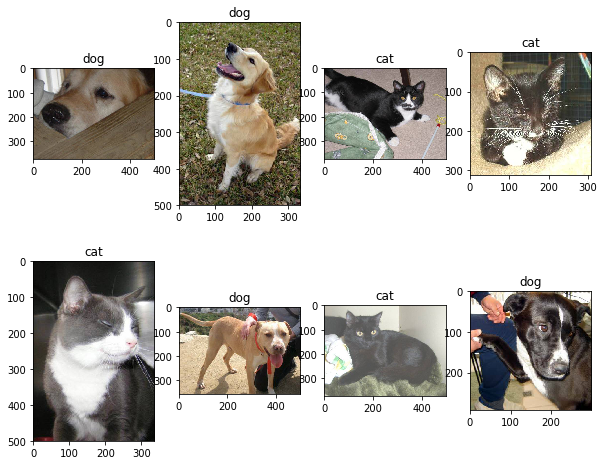

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 8))
for i, file in enumerate(os.listdir(train_dir)[:8]):
    img = plt.imread(os.path.join(train_dir, file))
    plt.subplot(2, 4, i+1)
    plt.title(file.split('.')[0])
    plt.axis('on')
    plt.imshow(img)
plt.show()

从上面的图示的结果来看，可以看出每张图片并不像我们预想的分辨率都一样大，那么，让获取每张图片的分辨率以及通道数，来对分辨率进行统计分析。

In [8]:
import os
import cv2
from tqdm import tqdm

train_info = [[],[]]
outside = []
train_img_list = list(filter(lambda x:x[-3:] == 'jpg', os.listdir(train_dir)))
for img in tqdm(train_img_list):
    info = cv2.imread(os.path.join(train_dir, img))
    train_info[0].append(info.shape[0])
    train_info[1].append(info.shape[1])
    if(info.shape[0] > 600):
        outside.append(train_dir+img)

100%|██████████| 25000/25000 [00:36<00:00, 694.42it/s]


In [9]:
print(outside)

['/home/willow/p7/dogvscat/train/dog.2317.jpg', '/home/willow/p7/dogvscat/train/cat.835.jpg']


图示化分析图片的分辨率

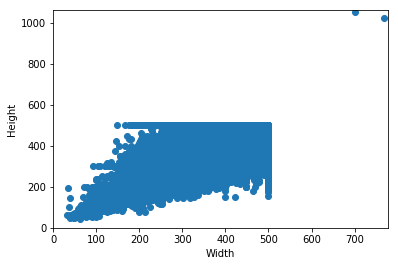

In [10]:
plt.scatter(train_info[0], train_info[1])
plt.xlabel('Width')
plt.ylabel('Height') 
plt.xlim(0,max(train_info[0]) + 10)
plt.ylim(0,max(train_info[1]) + 10)  
plt.show()

从图表中可以看出图片的宽度和高度基本都遍布在100-500之间。

删除那两张超出平均分辨率很多的图片

In [11]:
for img in outside:
    os.remove(img)

#### 4、数据预处理
为了尽量利用我们有限的训练数据，我们将通过一系列随机变换堆数据进行提升，这样我们的模型将看不到任何两张完全相同的图片，这有利于我们抑制过拟合，使得模型的泛化能力更好。

这个步骤可以通过keras.preprocessing.image.ImageGenerator来实现，下面我们来展示下这个预处理函数实现后的结果。

Using TensorFlow backend.


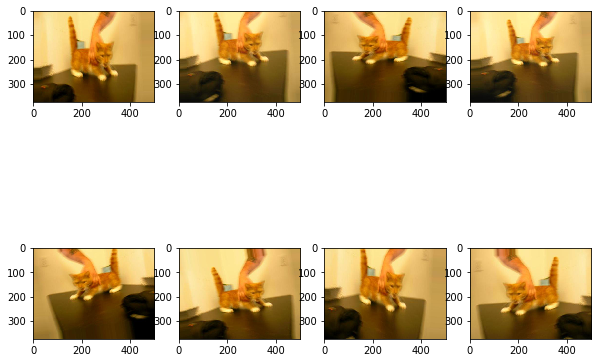

In [12]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import os

temp = ImageDataGenerator(
                        rotation_range = 10,
                        zoom_range = 0.2,
                        width_shift_range = 0.05,
                        height_shift_range = 0.1,
                        channel_shift_range=10,
                        horizontal_flip=True)

img = load_img(train_dir + '/cat.0.jpg')  
x = img_to_array(img)  
x = x.reshape((1,) + x.shape)

if(os.path.exists("preview")):
    shutil.rmtree("preview")
os.mkdir("preview")
i = 0
for batch in temp.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i >= 8:
        break

plt.figure(figsize=(10, 8))
for i, file in enumerate(os.listdir("preview")):
    img = plt.imread(os.path.join("preview", file))
    plt.subplot(2, 4, i+1)
    plt.axis('on')
    plt.imshow(img)
plt.show()

接着要进行我们的数据清洗工作，因为我们的图片保不齐有一些图并不是我们的猫狗类别的图像，这样对我们的算法上可能会造成一些影响，所以要对不是猫狗的图进行一下清洗。清洗的方法参考[这个链接](https://zhuanlan.zhihu.com/p/34068451)，使用imagenet上top几来进行分类。我还找到了一个[马桶的例子](https://blog.csdn.net/lauyeed/article/details/78886830)，感觉也很实用。

首先把前辈整理好的猫狗种类偷下来整理成列表。

In [13]:
dogs_cats = [
 'n02085620','n02085782','n02085936','n02086079'
,'n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364'
,'n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721'
,'n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339'
,'n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258'
,'n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437'
,'n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105'
,'n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236'
,'n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177'
,'n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251'
,'n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550'
,'n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089'
,'n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185'
,'n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889'
,'n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712'
,'n02113799','n02113978','n02123045','n02123159'
,'n02123394','n02123597','n02124075','n02125311'
,'n02127052']

查找，显示，并删除异常数据。

In [14]:
from keras.applications.resnet50 import preprocess_input, decode_predictions 
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
import numpy as np
def find_dirty_img(train_dir, dogs_cats,top = 10):
    dirty_imgs = []
    pathlist = os.listdir(train_dir)
    model = ResNet50(weights='imagenet')
    for i in pathlist:
        img = image.load_img(train_dir + i, target_size=(224, 224))  
        img = image.img_to_array(img)  
        x = np.expand_dims(img, axis=0)  
        x = preprocess_input(x)  
        preds = model.predict(x)
        preds = decode_predictions(preds, top=top)[0] 
        preds_list = list(zip(*preds))[0]
        if set(preds_list)&set(dogs_cats):
            continue
        else:
            dirty_imgs.append(train_dir + i)
            imgs = cv2.imread(train_dir + i)
            plt.imshow(imgs)
            plt.axis('on')
            plt.title(i)
            plt.show()
    return dirty_imgs

40960/35363 [==================================] - 0s 9us/step


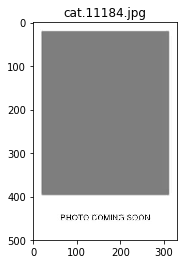

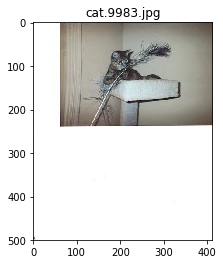

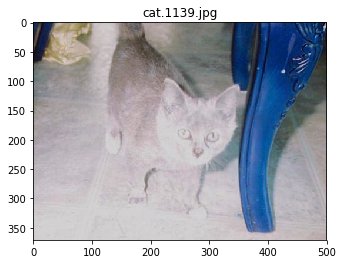

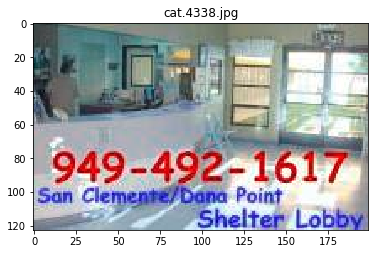

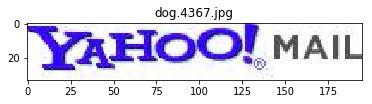

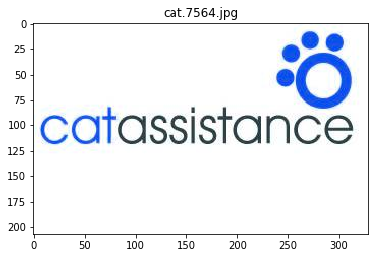

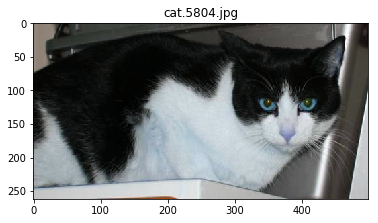

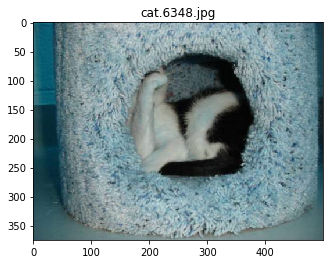

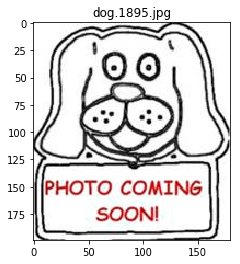

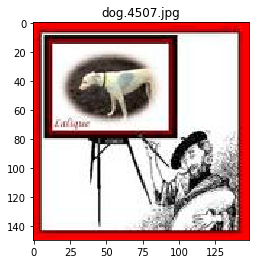

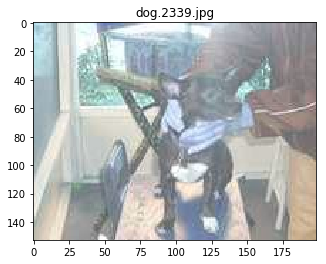

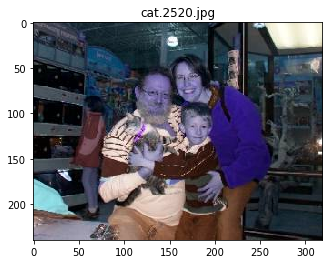

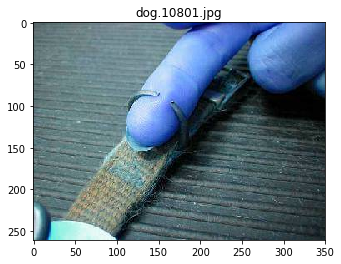

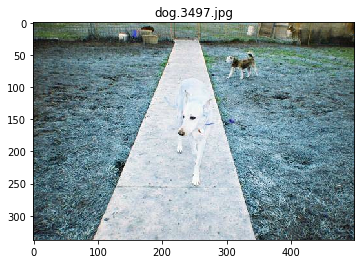

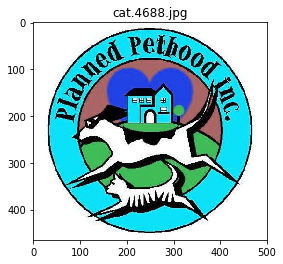

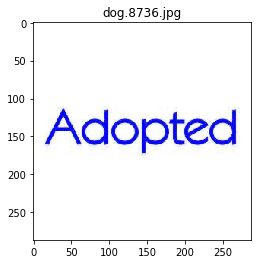

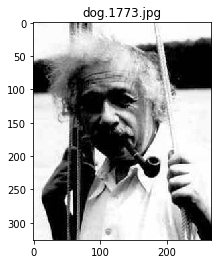

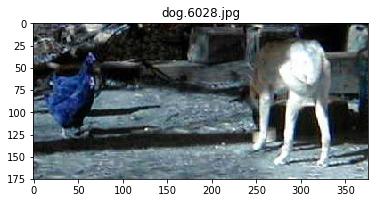

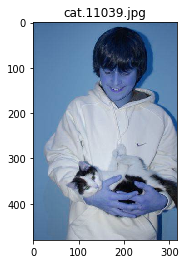

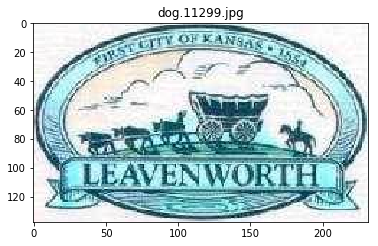

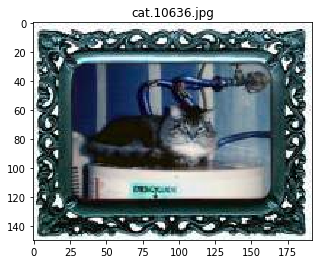

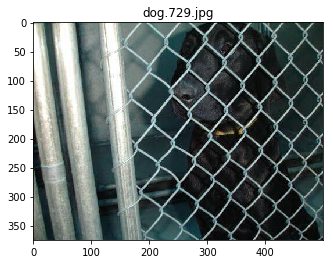

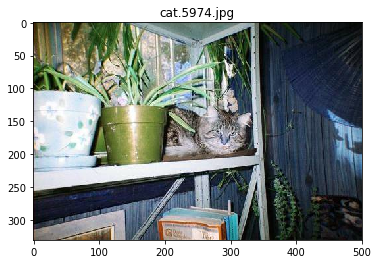

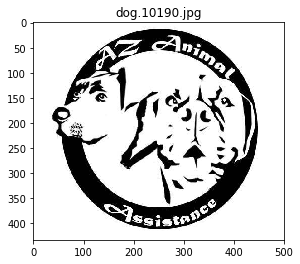

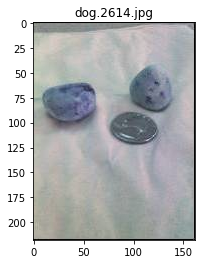

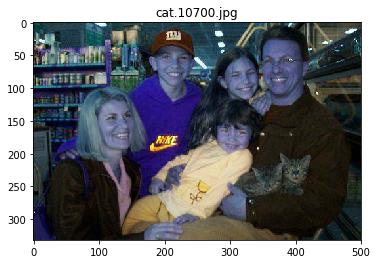

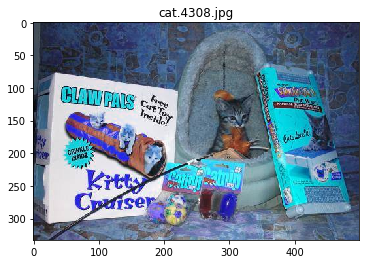

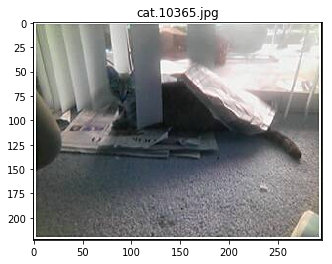

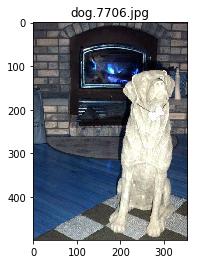

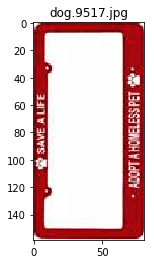

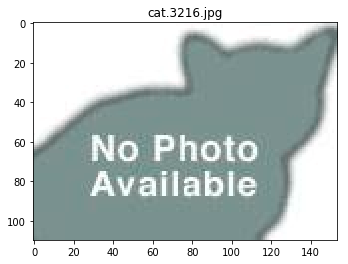

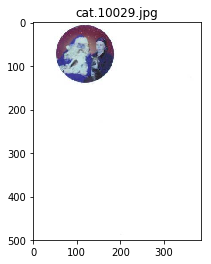

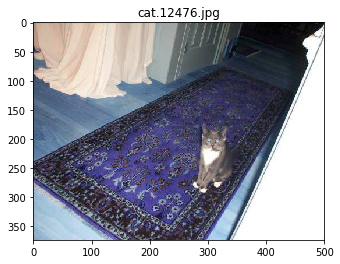

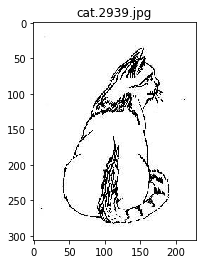

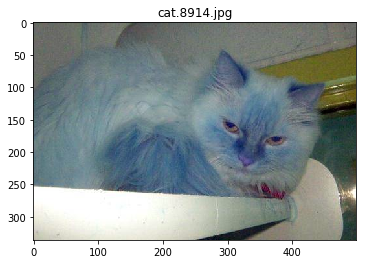

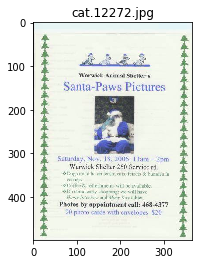

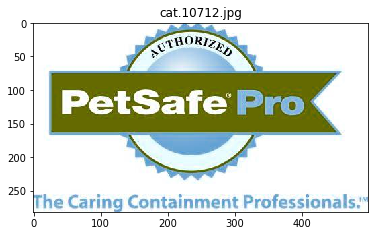

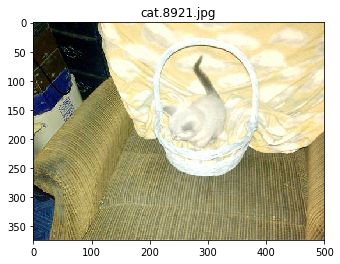

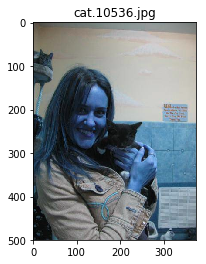

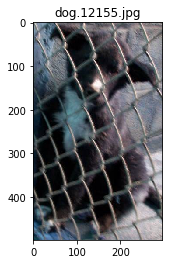

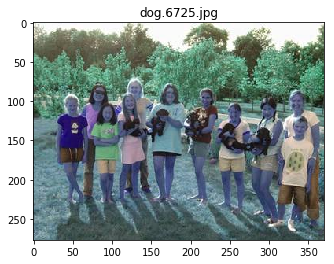

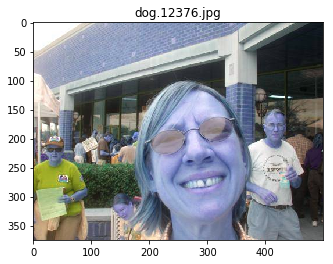

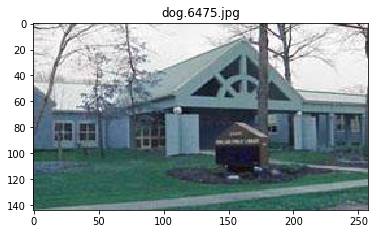

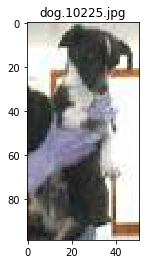

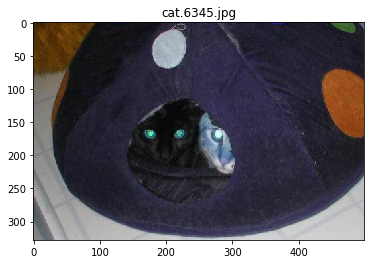

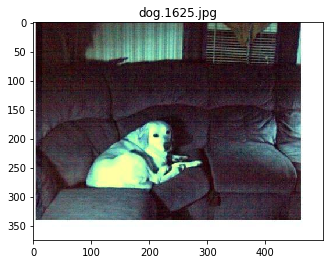

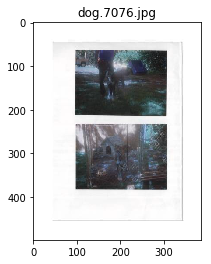

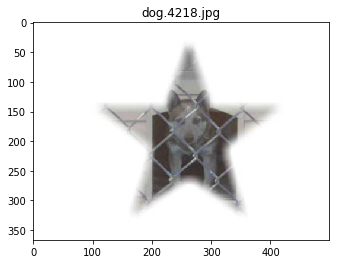

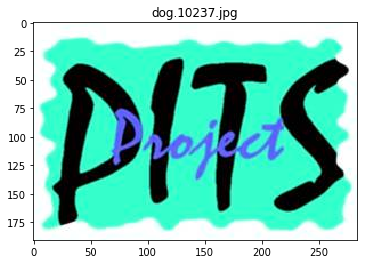

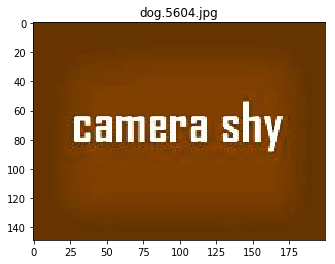

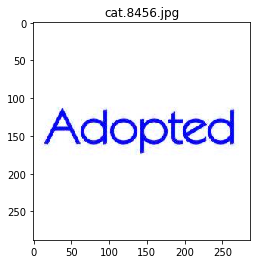

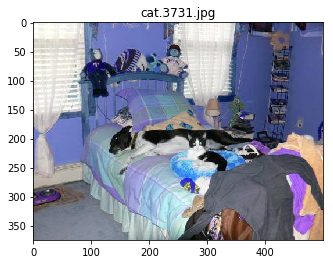

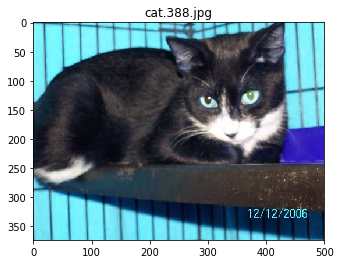

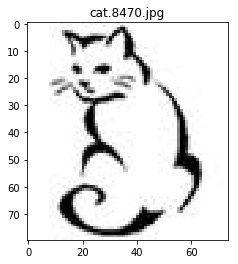

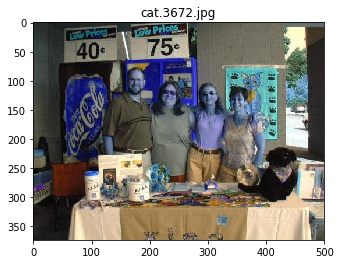

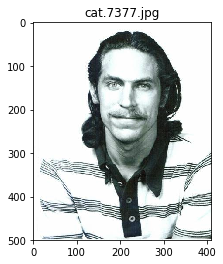

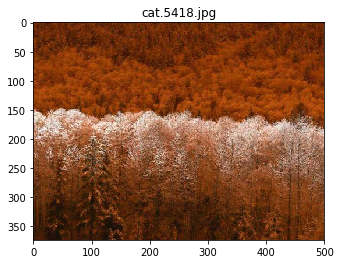

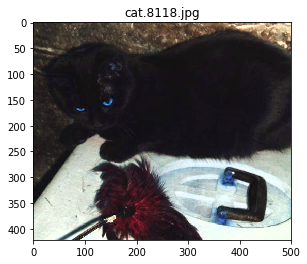

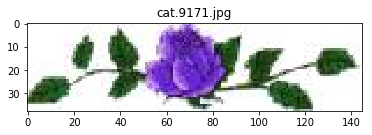

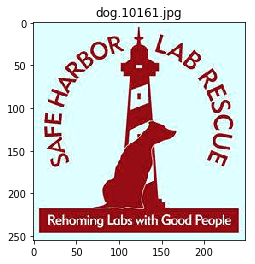

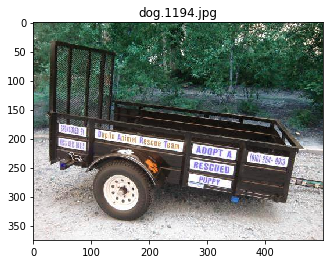

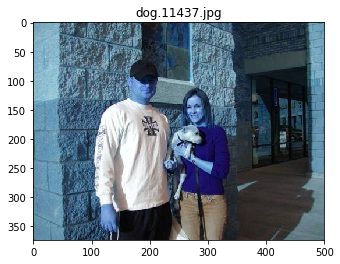

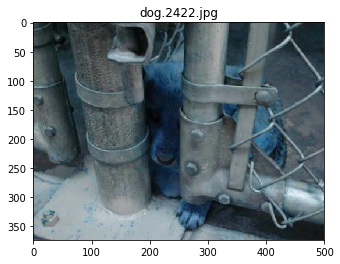

In [15]:
dirty_imgs = find_dirty_img(train_dir, dogs_cats, top = 35)

In [16]:
print(dirty_imgs, len(dirty_imgs))

['/home/willow/p7/dogvscat/train/cat.11184.jpg', '/home/willow/p7/dogvscat/train/cat.9983.jpg', '/home/willow/p7/dogvscat/train/cat.1139.jpg', '/home/willow/p7/dogvscat/train/cat.4338.jpg', '/home/willow/p7/dogvscat/train/dog.4367.jpg', '/home/willow/p7/dogvscat/train/cat.7564.jpg', '/home/willow/p7/dogvscat/train/cat.5804.jpg', '/home/willow/p7/dogvscat/train/cat.6348.jpg', '/home/willow/p7/dogvscat/train/dog.1895.jpg', '/home/willow/p7/dogvscat/train/dog.4507.jpg', '/home/willow/p7/dogvscat/train/dog.2339.jpg', '/home/willow/p7/dogvscat/train/cat.2520.jpg', '/home/willow/p7/dogvscat/train/dog.10801.jpg', '/home/willow/p7/dogvscat/train/dog.3497.jpg', '/home/willow/p7/dogvscat/train/cat.4688.jpg', '/home/willow/p7/dogvscat/train/dog.8736.jpg', '/home/willow/p7/dogvscat/train/dog.1773.jpg', '/home/willow/p7/dogvscat/train/dog.6028.jpg', '/home/willow/p7/dogvscat/train/cat.11039.jpg', '/home/willow/p7/dogvscat/train/dog.11299.jpg', '/home/willow/p7/dogvscat/train/cat.10636.jpg', '/home/

可以看到共筛选出63个异常值，有些人多于宠物的，有些是奇怪图形的等等，我们现在将他们从文件中删除。

In [17]:
for img in dirty_imgs:
    os.remove(img)

删除后的文件总数有24935个。

In [18]:
train_list = os.listdir(train_dir)
len(train_list)

24935

在剔除脏文件后，我们对train的文件进行链接，用来做后面的算法实施。

In [19]:
# symbol link train2
train_filenames = os.listdir(train_dir)
train_cat = list(filter(lambda x:x[:3] == 'cat', train_filenames))
train_dog = list(filter(lambda x:x[:3] == 'dog', train_filenames))

for i in tqdm(range(len(train_cat))):
    os.symlink(train_dir + train_cat[i], img_train2 + "cat/" + train_cat[i])
for i in tqdm(range(len(train_dog))):
    os.symlink(train_dir + train_dog[i], img_train2 + "dog/" + train_dog[i])

100%|██████████| 12470/12470 [00:00<00:00, 98702.92it/s]


In [20]:
#link valid train
for i in tqdm(range(len(train_cat))):
    if i < (len(train_cat) * 0.2):
        os.symlink(train_dir + train_cat[i], img_valid_cat + train_cat[i])
    else:
        os.symlink(train_dir + train_cat[i], img_train_cat + train_cat[i])
for i in tqdm(range(len(train_dog))):
    if i < (len(train_cat) * 0.2):
        os.symlink(train_dir + train_dog[i], img_valid_dog+ train_dog[i])
    else:
        os.symlink(train_dir + train_dog[i], img_train_dog + train_dog[i])

100%|██████████| 12470/12470 [00:00<00:00, 97213.08it/s]


### 二、算法实施
### 类构建
我首先实现一个类，可以进行对一些基础模型进行迁移，和fine-tune的操作。为后面的模型训练提取等做准备

In [63]:
import numpy as np
from keras.layers import *
from keras.preprocessing.image import *
from keras.models import *
from keras.callbacks import *
import matplotlib.pyplot as plt
import pandas as pd
from keras.applications import *

class CNN(object):
    np.random.seed(23)

    def __init__(self, model, train_dir, val_dir, test_dir, train_full_dir, batch_size=32,
                 img_sz=(224, 224), preprocess_func=None):
        self.train_dir = train_dir
        self.train_full_dir = train_full_dir
        self.val_dir = val_dir
        self.test_dir = test_dir
        self.img_sz = img_sz
        if preprocess_func:
            self.preprocess_input = preprocess_func

        train_generator = ImageDataGenerator(
            preprocessing_function=self.preprocess_input,
            rotation_range=10,
            width_shift_range=0.05,
            height_shift_range=0.05,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True)
        self.train_ge = train_generator.flow_from_directory(
            self.train_dir,
            target_size=self.img_sz,
            batch_size=batch_size,
            shuffle=True,
            class_mode='binary')

        val_generator = ImageDataGenerator(preprocessing_function=self.preprocess_input)
        self.val_ge = val_generator.flow_from_directory(
            self.val_dir,
            target_size=self.img_sz,
            batch_size=batch_size,
            shuffle=True,
            class_mode='binary')

        self.test_ge = val_generator.flow_from_directory(
            self.test_dir,
            target_size=self.img_sz,
            batch_size=batch_size,
            shuffle=False,
            class_mode=None)

        input_tensor = Input((img_sz[0], img_sz[1], 3))
        self.base_model = model(input_tensor=input_tensor, weights='imagenet', include_top=False, pooling = 'avg')
        self.model_name = self.base_model.name
        for layer in self.base_model.layers:
            layer.trainable = False

        x = self.base_model.output
        x = Dropout(0.5)(x)

        output = Dense(1, activation='sigmoid')(x)

        self.model = Model(inputs=self.base_model.input, outputs=output)
        self.model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

    def fit(self, epochs = 5, steps_train = 650, steps_valid = 150):
        check_point = ModelCheckpoint(
            self.model_name +'_'+'freeze_base.hdf5',
            monitor='val_loss',
            mode='min',
            verbose=1,
            save_best_only=True,
            save_weights_only=True)

        self.result = self.model.fit_generator(
            self.train_ge,
            steps_per_epoch=steps_train,
            epochs=epochs,
            validation_data=self.val_ge,
            validation_steps=steps_valid,
            callbacks=[check_point])
    def visualization(self):
        history = self.result.history
        fig = plt.figure(figsize=(8, 5))

        y1 = fig.add_subplot(111)
        p1 = y1.plot(history['val_loss'], label="val_loss", color='r')
        y1.set_ylabel('binary_crossentropy')
        y1.set_xlabel('epochs')
        y2 = y1.twinx()
        p2 = y2.plot(history['val_acc'], label="val_acc", color='b')
        y2.set_ylabel('accuracy')
        lns = p1+p2
        labs = [l.get_label() for l in lns]
        y1.legend(lns, labs, loc='center right')
        plt.show()

    def fit_finetune(self, fine_tune_layer, filename = None, epochs = 5, steps_train = 1000, steps_valid = 100):
        if filename != None:
            model.load_weights(filename)
        for layer in self.model.layers:
            layer.trainable = False
        for layer in self.model.layers[-fine_tune_layer:]:
            layer.trainable = True
        self.model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
        check_point = ModelCheckpoint(
            self.model_name + '_finetune_' + str(fine_tune_layer) +'.hdf5',
            monitor='val_loss',
            mode='min',
            verbose=1,
            save_best_only=True,
            save_weights_only=True)

        self.result = self.model.fit_generator(
            self.train_ge,
            steps_per_epoch=steps_train,
            epochs=epochs,
            validation_data=self.val_ge,
            validation_steps=steps_valid,
            callbacks=[check_point])

    def summary(self):
        self.model.summary()

    def predict(self, name = None):
        self.predict_ge = self.model.predict_generator(self.test_ge, verbose=1)
        self.predict_ge = self.predict_ge.clip(min=0.005, max=0.995)
        if name == None:
            name = " "
        df = pd.read_csv("sample_submission.csv")
        for i, fname in enumerate(self.test_ge.filenames):
            index = int(fname.split('/')[1].split('.')[0])
            df.set_value(index - 1, 'label', self.predict_ge[i])

        outfile = 'pred_' + self.model_name + name + '.csv'
        print('Saving test result on: ' + outfile)
        df.to_csv(outfile, index=None)
        print("save_predict in: " + outfile)
        return df

    def write_feature(self, name = None):
        model = Model(self.model.input, self.model.layers[-3].output)
        print('The output of model: ', model.output)
        if name == None:
            name = " "
        print('Data augmentation')
        gen = ImageDataGenerator(
            preprocessing_function=self.preprocess_input,
        )

        train_gen = gen.flow_from_directory(
            self.train_full_dir,
            target_size=self.img_sz,
            shuffle=False,
            batch_size=128,
            class_mode=None,
        )

        self.train_gen_full = train_gen
        test_gen = self.test_ge

        print('feature from train data ...' )
        train = model.predict_generator(train_gen, verbose=1)
        print('feature from test data ...' )
        test = model.predict_generator(test_gen, verbose=1)

        fn = "feature_%s.h5"%self.model_name+name
        print('Write feature to file: ' + fn)
        with h5py.File(fn) as h:
            h.create_dataset("train", data=train)
            h.create_dataset("label", data=train_gen.classes)
            h.create_dataset("test", data=test)

### 单模型提取特征向量
### 1. Xception

In [64]:
cnn_xception = CNN(xception.Xception, img_train, img_valid, img_test, img_train2,
               batch_size=128, img_sz=(299, 299), preprocess_func= xception.preprocess_input)

Found 19949 images belonging to 2 classes.
Found 4986 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


先来看下模型信息:

In [65]:
cnn_xception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_15[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

提取特征向量：

In [66]:
cnn_xception.write_feature()

The output of model:  Tensor("global_average_pooling2d_14/Mean:0", shape=(?, 2048), dtype=float32)
Data augmentation
Found 24935 images belonging to 2 classes.
feature from train data ...
195/195 [==============================] - 188s 964ms/step
feature from test data ...
98/98 [==============================] - 90s 914ms/step
Write feature to file: feature_xception.h5 


### 2. ResNet50

In [69]:
from keras.applications import imagenet_utils

In [70]:
cnn_resnet50 = CNN(resnet50.ResNet50, img_train, img_valid, img_test, img_train2,
                batch_size=128, preprocess_func= imagenet_utils.preprocess_input)

Found 19949 images belonging to 2 classes.
Found 4986 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
94658560/94653016 [==============================] - 26s 0us/step


先来看下模型信息:

In [71]:
cnn_resnet50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_16[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

提取特征向量：

In [72]:
cnn_resnet50.write_feature()

The output of model:  Tensor("global_average_pooling2d_15/Mean:0", shape=(?, 2048), dtype=float32)
Data augmentation
Found 24935 images belonging to 2 classes.
feature from train data ...
195/195 [==============================] - 160s 818ms/step
feature from test data ...
98/98 [==============================] - 77s 786ms/step
Write feature to file: feature_resnet50.h5 


### 3. InceptionV3

In [74]:
cnn_inceptionv3 = CNN(inception_v3.InceptionV3, img_train, img_valid, img_test, img_train2,
                   batch_size=128, preprocess_func= inception_resnet_v2.preprocess_input)

Found 19949 images belonging to 2 classes.
Found 4986 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
87916544/87910968 [==============================] - 11s 0us/step


先来看下模型信息:

In [75]:
cnn_inceptionv3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 111, 111, 32) 864         input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 111, 111, 32) 96          conv2d_57[0][0]                  
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 111, 111, 32) 0           batch_normalization_57[0][0]     
__________________________________________________________________________________________________
conv2d_58 

提取特征向量：

In [76]:
cnn_inceptionv3.write_feature()

The output of model:  Tensor("global_average_pooling2d_16/Mean:0", shape=(?, 2048), dtype=float32)
Data augmentation
Found 24935 images belonging to 2 classes.
feature from train data ...
195/195 [==============================] - 153s 783ms/step
feature from test data ...
98/98 [==============================] - 73s 748ms/step
Write feature to file: feature_inception_v3.h5 


### 构建融合模型
### 1. 模型可视化

In [73]:
digraph G{
    node [shape=record]
    a[label="ResNet50|{input:|output:}|{(224, 224, 3)|(2048)}"]
    b[label="InceptionV3|{input:|output:}|{(299, 299, 3)|(2048)}"]
    c[label="Xception|{input:|output:}|{(299, 299, 3)|(2048)}"]
    Merge[label="Merge|{input:|output:}|{(3, 2048)|(6144)}"]
    Dropout[label="Dropout|Rate:|0.5"]
    Output[label="Output|{input:|output:}|{(6144)|(1)}"]
    Image -> a -> Merge
    Image -> b -> Merge
    Image -> c -> Merge
    Merge -> Dropout -> Output
}

SyntaxError: invalid syntax (<ipython-input-73-bad78206b41c>, line 1)

训练模型:

In [35]:
cnn_xception.fit()

Epoch 1/5
281/650 [===========>..................] - ETA: 16:32 - loss: 0.1407 - acc: 0.9663

KeyboardInterrupt: 

In [ ]:
cnn_xception.visualization()

对当前这个全冻结模型进行测试：

In [ ]:
cnn_xception.predict()

当前fine-tune模型得到结果为：

接下来提取当前模型的特征向量，用于后面的模型融合

In [ ]:
cnn_xception.write_feature()

### 2. ResNet50
全冻结模型进行训练

In [ ]:
cnn_resnet50.fit()

In [ ]:
cnn_resnet50.predict()

In [ ]:
cnn_resnet50.write_feature()

### InceptionV3

In [ ]:
cnn_inceptionv2.fit()

In [ ]:
cnn_inceptionv2.predict()

In [ ]:
cnn_inceptionv2.write_feature()

### 模型融合